# Health Insurance Cross-Sell
---

The Insurance All company provides health insurance to your clients as main service for a long time, however, the sales team in interested in offering a new service: A car insurance.

Customers with the company service must pay an amount annually in order to be insured for an eventual incident. Last year, the marketing team conducted a survey with 380,000 people asking about some interest in joining into a new car insurance. The responses from clients who showed interest or not in purchasing an auto insurance were saved in a database with others attributes. The product team selected 127,000 new customers who did not respond to the survey to participate in a campaign, in which they will receive an offer of the new car insurance product. The offer will be made by the sales team through phone calls. However, the sales team has the capacity to make 20 thousand calls within the campaign period.

As a Data Scientist, your goal is to build a model that classifies a list of customers, informing the customer's possibility of contracting or not a car insurance. With the solution, the sales team hopes to be able to prioritize people with the greatest interest in the new product and thus optimize the campaign by only making contact with the customers most likely to make a purchase. In addition to the model, a report will be delivered containing the following information:

1. Key Insights on the most relevant attributes of customers interested in purchasing auto insurance.Key Insights with the most relevant attributes of selected customers in purchasing auto insurance.
2. What percentage of interested customers the sales team will be able to contact making 20,000 calls?
3. By increasing the capacity to 40,000 calls, what percentage of interested customers the sales team will be able to contact?
4. How many calls does sales team need to make to reach 80% of the most likely customers to purchase the car insurance?


> Disclaimer: This is a fictional bussiness case

## PLANNING

### Input

- Predict wheter customer will be interested in the car insurance;
- Database with customers answers and info.

### Output

- Customers interested in car insurance;
- Performance of the model;
- Percentage of the customers reached with calls;
- Report

### Tasks

1. Which customer will be interested in the insurance?
    - Which customers have a DL?
    - What is the vehicle age range with more interested customer?

2. Performance of the model:
    - Cumulative Gain
    - Lift Curve

3. Action plan:
    - Phone Calls with the customers with the highest probability to take out the insurance

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot        as plt
import seaborn as sns
import psycopg2 as pg

from sklearn.ensemble                       import RandomForestClassifier
from sklearn.linear_model                   import LogisticRegression
from sklearn.metrics                        import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
from sklearn.preprocessing                  import MinMaxScaler, RobustScaler
from typing                                 import Union
from IPython.core.display                   import HTML
from sklearn.model_selection                import train_test_split

## HELPER FUNCTIONS AND SETTINGS

In [2]:
def numerical_metrics(numerical_attributes: Union[int, float]):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
    
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes


def categorical_metrics(data: Union[int, str], col: str):

    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    

    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })


def multiple_histplots(data: Union[int, float, str], rows: int, cols: int):


    """
    Shows a matrix with hisplots of selected features.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with histplots]
    """


    for i, col in enumerate(data.columns, 1):
        plt.subplot(rows,cols,i)
        ax = sns.histplot(data[col], kde = True)
        plt.ylabel('')
        plt.style.use('tableau-colorblind10')

    return ax


def model_metrics(models: str, X_test: Union[int, float, str], y_test: float):
    """Calculate Precision, Recall and F1

    Args:
        models[list]: [List of Machine Learning Algorithms]
        X_test: [Features Test Dataframe]
        y_test: [Target Feature Test DataFrame]

    Returns:
        [DataFrame]: [DataFrame with metrics]
    """

    result_df = []
    for model in models:
        # model prediction
        model_name = type(model).__name__
        yhat = model.predict(X_test)
        yhat_proba = model.predict_proba(X_test)
        yhat_proba = yhat_proba[:, 1]
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        rocauc = roc_auc_score(y_test, yhat_proba)
        model_metrics = pd.DataFrame( { 'Model Name': model_name,
                                        'Accuracy': accuracy,
                                        'Precision': precision,
                                        'Recall': recall,
                                        'F1-Score': f1,
                                        'ROCAUC': rocauc},  index = [0])
        result_df.append(model_metrics)

    result = pd.concat(result_df)
    
    return result


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()


# round
pd.options.display.float_format = '{:.3f}'.format


seed = 42


Populating the interactive namespace from numpy and matplotlib


In [3]:
homepath = '/home/guttofranca/Repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'


## DATA


This dataset is avaliable [here](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).

**Data fields**

- **id**: Unique ID for the customer
- **gender**: Gender of the customer
- **age**: Age of the customer
- **driving_license**: 0 : Customer does not have DL, 1 : Customer already has DL
- **region_code**: Unique code for the region of the customer
- **previously_insured**: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
- **vehicle_age**: Age of the Vehicle
- **vehicle_damage**: 1 : Customer got his/her vehicle damaged in the past, 0 : Customer didn't get his/her vehicle damaged in the past
- **annual_premium**: The amount customer needs to pay as premium in the year
- **policy_sales_channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- **vintage**: Number of Days, Customer has been associated with the company
- **response**: 1 : Customer is interested, 0 : Customer is not interested 


In [4]:
# Credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [5]:
conn = pg.connect(user = username, password = pwd, host = host, port = port, database = database)

query_schema = '''
    SELECT *
    FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
                        INNER JOIN pa004.insurance i on (u.id = i.id)
'''

df_raw = pd.read_sql(query_schema, conn)

conn.close()

df_raw.to_pickle(homepath + 'data/processed/df_raw.pkl')

## 1. DATA DESCRIPTION


- **Tasks**
    - Dataset First Look
    - Organizing Columns
    - Data Dimensions
    - Check Data
    - Unique Values
    - Descriptive Statistics


### 1.1 Dataset First Look


In [6]:
df1 = pd.read_pickle(homepath + 'data/processed/df_raw.pkl')

In [7]:
df1.head(2)

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.000,152.000,7,1,< 1 Year,Yes,7,0,23367.000,249,0
1,13,Female,41,15.000,14.000,13,1,1-2 Year,No,13,1,31409.000,221,0


### 1.2 Organizing Columns


In [8]:
# removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

In [9]:
df1.head().T

,0,1,2,3,4
id,7,13,18,31,39
gender,Male,Female,Female,Female,Male
age,23,41,25,26,45
region_code,11.000,15.000,35.000,8.000,8.000
policy_sales_channel,152.000,14.000,152.000,160.000,124.000
driving_license,1,1,1,1,1
vehicle_age,< 1 Year,1-2 Year,< 1 Year,< 1 Year,1-2 Year
vehicle_damage,Yes,No,No,No,Yes
previously_insured,0,1,1,0,0
annual_premium,23367.000,31409.000,46622.000,2630.000,42297.000


### 1.3 Data Dimensions


In [10]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')


Number of rows: 381109 
Number of columns: 12


### 1.4 Check Data

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

This DataFrame doesn't have NA and the dtypes look right

In [13]:
df1['response'].value_counts(normalize = True)

0   0.877
1   0.123
Name: response, dtype: float64

### 1.5 unique Values

In [14]:
print(f'There are {df1["region_code"].nunique()} unique regions.')
print(f'There are {df1["vehicle_age"].nunique()} unique vehicle ages.')

There are 53 unique regions.
There are 3 unique vehicle ages.


In [15]:
df1['vehicle_age'].unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

Vehicle Age: < 1 year, 1-2 years, > 2 years

### 1.6 Descriptive Statistics

#### 1.6.1 Numerical Attributes

In [16]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
num_result = numerical_metrics(num_attributes)
num_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,age,20.000,85.000,65.000,38.823,36.000,25.000,49.000,15.512,0.673,-0.566
1,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,24405.000,39400.000,17213.132,1.766,34.005
2,vintage,10.000,299.000,289.000,154.347,154.000,82.000,227.000,83.671,0.003,-1.201


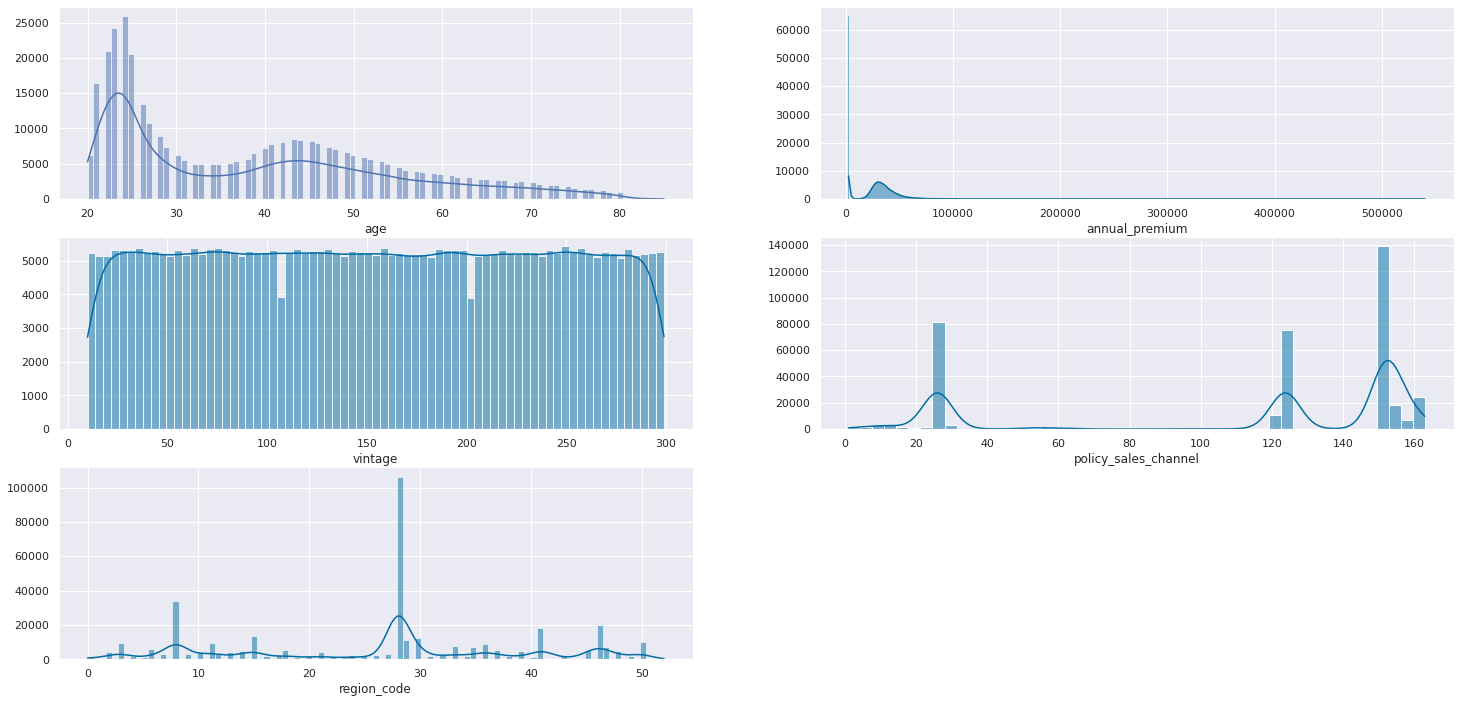

In [17]:
multiple_histplots(df1[['age', 'annual_premium', 'vintage', 'policy_sales_channel', 'region_code']], 3, 2);

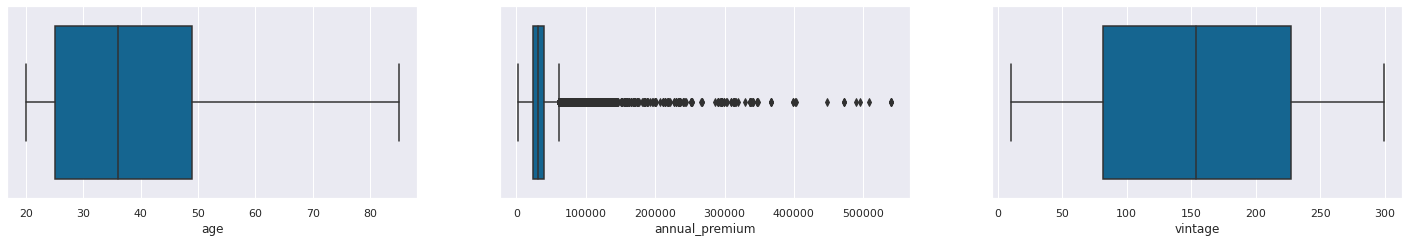

In [18]:
i = 1
for col in num_attributes:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = num_attributes, x = col)
    i += 1

The annual_premium will need an future analysis

#### 1.6.2 Categorical Attributes

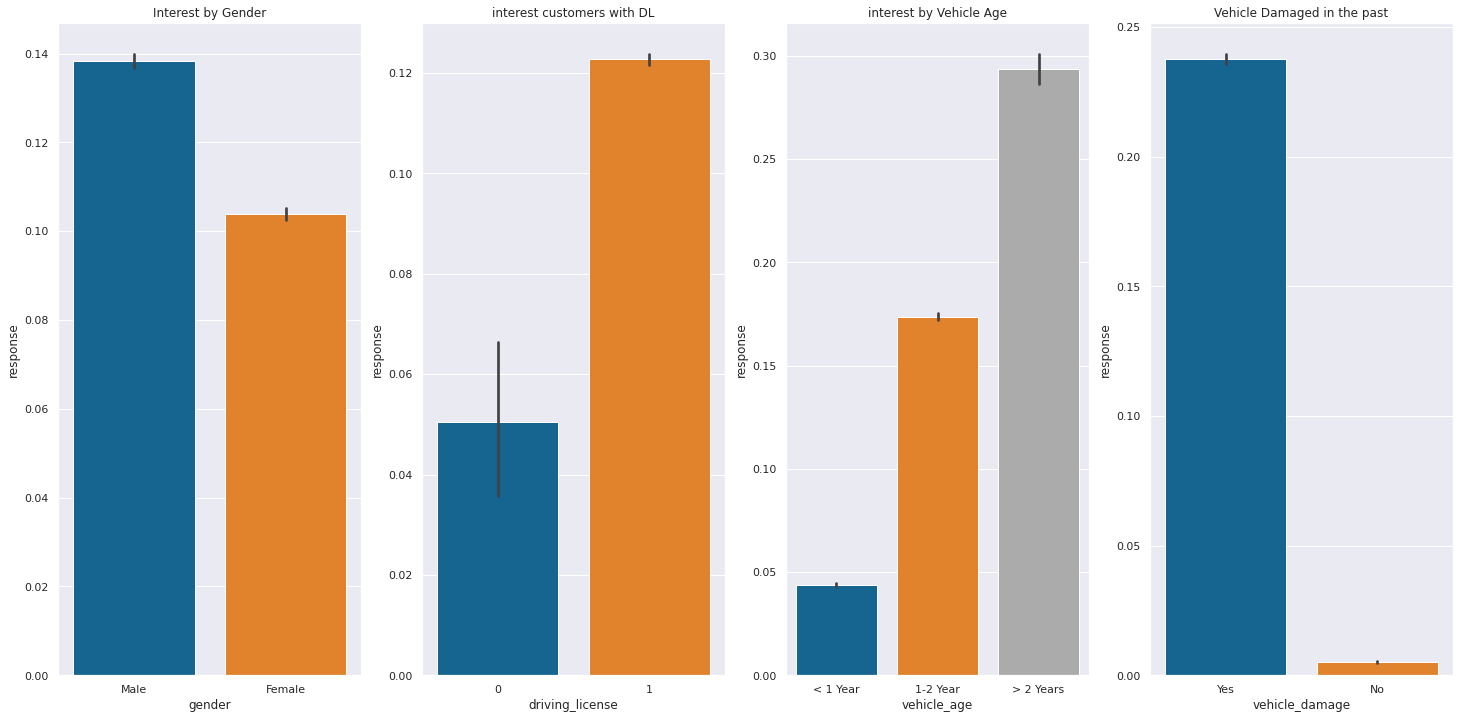

In [19]:
cat_attributes = df1[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

plt.subplot(1, 4, 1)
sns.barplot(x = 'gender', y = 'response', data = cat_attributes)
plt.title('Interest by Gender');

plt.subplot(1, 4, 2)
sns.barplot(x = 'driving_license', y = 'response', data = cat_attributes)
plt.title('interest customers with DL');

plt.subplot(1, 4, 3)
sns.barplot(x = 'vehicle_age', y = 'response', data = cat_attributes)
plt.title('interest by Vehicle Age');

plt.subplot(1, 4, 4)
sns.barplot(x = 'vehicle_damage', y = 'response', data = cat_attributes)
plt.title('Vehicle Damaged in the past');

Gender

In [20]:
categorical_metrics(cat_attributes, 'gender')

,absolute,percent %
Male,206089,54.076
Female,175020,45.924


Driving License

In [21]:
categorical_metrics(cat_attributes, 'driving_license')

,absolute,percent %
1,380297,99.787
0,812,0.213


In [22]:
aux = df1[df1['driving_license'] == 0]

categorical_metrics(aux, 'response')


,absolute,percent %
0,771,94.951
1,41,5.049


Vehicle Age

In [23]:
categorical_metrics(cat_attributes, 'vehicle_age')

,absolute,percent %
1-2 Year,200316,52.561
< 1 Year,164786,43.239
> 2 Years,16007,4.200


Vehicle Damage

In [24]:
categorical_metrics(cat_attributes, 'vehicle_damage')

,absolute,percent %
Yes,192413,50.488
No,188696,49.512


Previously Insured

In [25]:
categorical_metrics(cat_attributes, 'previously_insured')

,absolute,percent %
0,206481,54.179
1,174628,45.821


Target

In [26]:
categorical_metrics(cat_attributes, 'response')

,absolute,percent %
0,334399,87.744
1,46710,12.256


Only 12.256% of the clients shows interest in vehicle insurance

### 1.7 Save State

In [27]:
df1.to_pickle(homepath + 'data/processed/df1.pkl')


## 2. FEATURE ENGINEERING

- **Tasks**
    - Features Creatrion

### 2.1 Dataset Checkpoint


In [28]:
df2 = pd.read_pickle(homepath + 'data/processed/df1.pkl')

### 2. Save State

In [29]:
df2.to_pickle(homepath + 'data/processed/df2.pkl')

## 3. DATA FILTERING

- **Tasks**
    - Filtering Rows


### 3.1 Dataset Checkpoint


In [30]:
df3 = pd.read_pickle(homepath + 'data/processed/df2.pkl')

### 3. Save State


In [31]:
df3.to_pickle(homepath + 'data/processed/df3.pkl')

## 4. EXPLORATORY DATA ANALYSIS

### 4.1 Dataset Checkpoint


In [32]:
df4 = pd.read_pickle(homepath + 'data/processed/df3.pkl')

### 4. Save State


In [33]:
df4.to_pickle(homepath + 'data/processed/df4.pkl')

## 5. DATA PREPARATION

### 5.1 Dataset Checkpoint


In [34]:
df5 = pd.read_pickle(homepath + 'data/processed/df4.pkl')
df5.drop(columns = ['id'], inplace = True)

In [35]:
# Train -> 70%
# Test -> 20%
# Validation -> 10%

# target: response
y = df5['response']
X = df5.drop(columns = ['response'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# if train = 80% x dataset, then val = 0.1/0.8 = 0.125
# 0.125 x 0.8 = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = seed)

### 5.2 Encoding

In [36]:
# One Hot Encoding in 'vehicle_age', 'gender' and 'vehicle_damage'
# Frequency Encoding in 'policy_sales_channel', 'region_code'
gender_encoding = {'Male': 0, 'Female': 1}
question_encoding = {'No': 0, 'Yes': 1}
fe_cols = ['policy_sales_channel', 'region_code'] 

X_train, X_test, X_val = [pd.get_dummies(dataframe, prefix = ['car_age'],columns = ['vehicle_age']) for dataframe in [X_train, X_test, X_val]]
X_train, X_test, X_val = [  dataframe.rename(columns = {'car_age_1-2 Year': 'car_age_1-2_year',  'car_age_> 2 Years': 'car_age_>2_years',
                            'car_age_< 1 Year': 'car_age_<1_year'}) for dataframe in [X_train, X_test, X_val]]

for dataframe in [X_train, X_test, X_val]:
    dataframe['gender'] = dataframe['gender'].map(gender_encoding)
    dataframe['vehicle_damage'] = dataframe['vehicle_damage'].map(question_encoding)
    
    
for col_name in fe_cols:
    fe_train, fe_test, fe_val = [(dataframe.groupby(col_name).size())/len(dataframe) for dataframe in [X_train, X_test, X_val]]
    X_train.loc[:, col_name] = X_train[col_name].map(fe_train)
    X_test.loc[:, col_name] = X_test[col_name].map(fe_test)
    X_val.loc[:, col_name] = X_val[col_name].map(fe_val)

### 5.3 Rescaling

1. Without Outlier and With Normal Distribution: Standard Scaler (Mean and std deviation)
2. With Outliers and Normal Distribution: Robust Scaler (Quartile)
3. Without Normal Distribution: MinMax Scaler

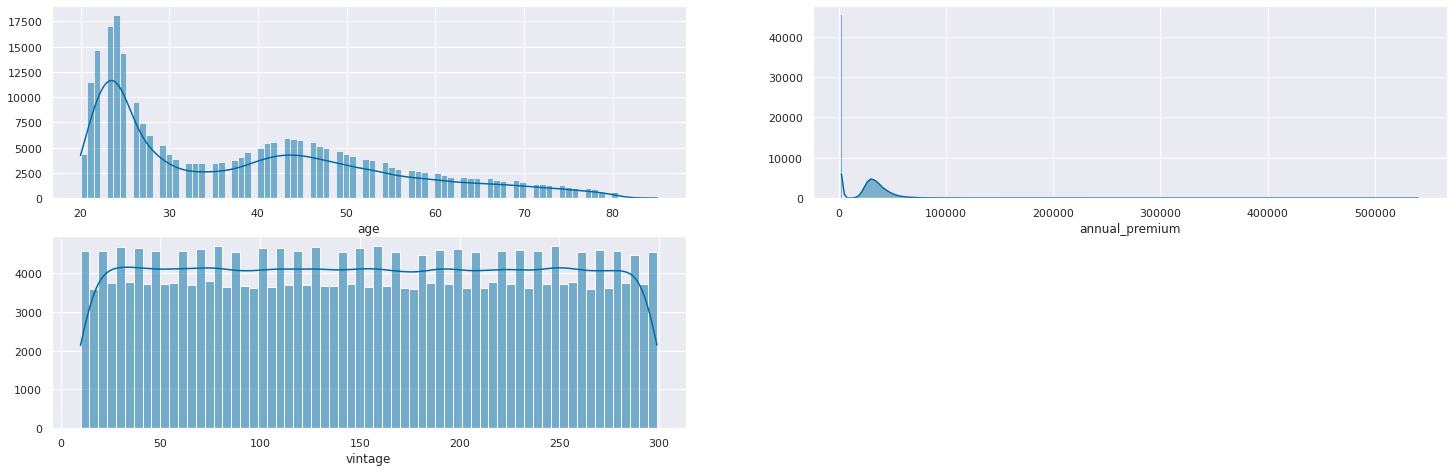

In [37]:
multiple_histplots(X_train[['age', 'annual_premium','vintage']], 3, 2);

In [38]:
# Min-Max Scaler
mms = MinMaxScaler()
rs = RobustScaler()

min_max_scaler = ['age', 'vintage']
robust_scaler = ['annual_premium']

for col in min_max_scaler:
    X_train[[col]] = mms.fit_transform(X_train[[col]].values)
    X_test[col] = mms.fit_transform(X_test[[col]].values)
    X_val[col] = mms.fit_transform(X_val[[col]].values)

for col in robust_scaler:
    X_train[[col]] = rs.fit_transform(X_train[[col]].values)
    X_test[col] = rs.fit_transform(X_test[[col]].values)
    X_val[col] = rs.fit_transform(X_val[[col]].values)

### 5.4 Feature Importance

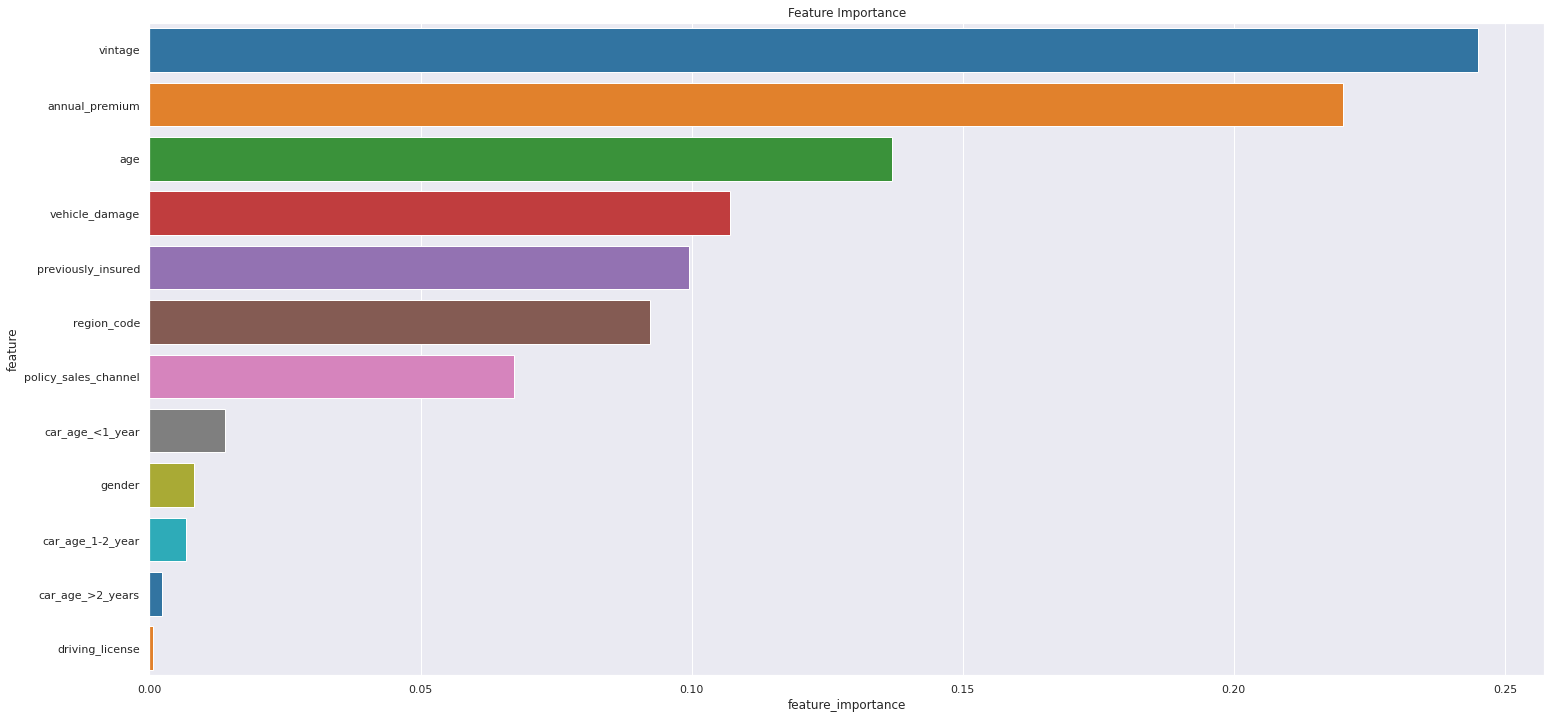

In [41]:
# train random forest
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = seed)
rf.fit(X_train, y_train)

# feature importance data frame
feature_selection = pd.DataFrame({'feature': X_train.columns,'feature_importance': rf.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

# plot feature importance
ax = sns.barplot(x = 'feature_importance', y = 'feature', data = feature_selection, orient = 'h', palette = 'tab10')
ax.set_title('Feature Importance');

### 5. Save State


## 6. MACHINE LEARNING MODELLING

In [44]:
from xgboost                                import XGBClassifier
from sklearn.linear_model                   import LogisticRegression
from sklearn.metrics                        import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 

In [45]:
# model definition
lr = LogisticRegression(random_state = seed, solver = 'lbfgs', max_iter = 1000)

# model training
lr.fit(X_train, y_train)

# model predictionb
yhat_lr = lr.predict_proba(X_val)

In [46]:
# model definition
rf = RandomForestClassifier(random_state = seed)

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(X_val)

In [53]:
def model_metrics(models, X_test, y_test):
    """Calculate Precision, Recall and F1

    Args:
        models[list]: [List of Machine Learning Algorithms]
        X_test: [Features Test Dataframe]
        y_test: [Target Feature Test DataFrame]

    Returns:
        [DataFrame]: [DataFrame with metrics]
    """

    result_df = []
    for model in models:
        # model prediction
        model_name = type(model).__name__
        yhat = model.predict(X_test)
        yhat_proba = model.predict_proba(X_test)
        yhat_proba = yhat_proba[:, 1]
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        rocauc = roc_auc_score(y_test, yhat_proba)
        model_metrics = pd.DataFrame( { 'Model Name': model_name,
                                        'Accuracy': accuracy,
                                        'Precision': precision,
                                        'Recall': recall,
                                        'F1-Score': f1,
                                        'ROCAUC': rocauc},  index = [0])
        result_df.append(model_metrics)

    result = pd.concat(result_df)
    
    return result

In [54]:
models = [lr, rf]
model_metrics(models, X_val, y_val)

,Model Name,Accuracy,Precision,Recall,F1-Score,ROCAUC
0,LogisticRegression,0.879,0.500,0.000,0.000,0.833
0,RandomForestClassifier,0.867,0.340,0.108,0.164,0.833


## 7. HYPERPARAMETER FINE TUNNING

## 8. TUNNED MODEL PERFORMANCE

## 9. BUSINESS TRANSLATION